### this script calculates similarity between sequnces from a given session , given indiual and given stage  

we first load the sequnce data and group it for further distance calculation, we then caculate distance matrix between sequnce repetoirs using 1. transition probability 2. bi-grmas 3. local aligment 4. repeat dstribtuion of phee calls

In [9]:
# 1. Imports, base paths, colour palette
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from itertools import combinations
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform        # classic import
# or, equivalently
from scipy.spatial import distance as ssd
# then use: D_bigram_eu = ssd.squareform(ssd.pdist(B, metric="euclidean"))


# ── project folders (relative to notebook in …/2025/code/) ──────
BASE_DIR      = Path.cwd().parent
SEQ_DATA_DIR  = BASE_DIR / "seqeunce data"

CSV_PATH      = SEQ_DATA_DIR / "Processed_seq_data.csv"     # master CSV

# ── plot palette (unchanged) ────────────────────────────────────
PALETTE = {"Tabor":"#2e1571","Odin":"#df2e12","Wuschel":"#6D9290",
           "Lola":"#4725DD","Nougatti":"#ffd700","Olympia":"#ffffff"}
STAGE_MARKER = {"before":"o","after":"^"}

# %% ------------------------------------------------------------
# 2.  Load CSV  →  keep only valid sequences
# ---------------------------------------------------------------
keep_cols = ["stage","type","date_x","time_x","focal ID","Date_Time",
             "experimenter","session_number","conspecific_ID","seq_num",
             "sequence","true_sequence","phase","paired_status"]

df = (pd.read_csv(CSV_PATH, usecols=keep_cols)
        .dropna(subset=["true_sequence"]))

In [2]:
# %% ------------------------------------------------------------
# 1. Imports, base paths, colour palette
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from itertools import combinations
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform        # classic import
# or, equivalently
from scipy.spatial import distance as ssd
# then use: D_bigram_eu = ssd.squareform(ssd.pdist(B, metric="euclidean"))


# ── project folders (relative to notebook in …/2025/code/) ──────
BASE_DIR      = Path.cwd().parent
SEQ_DATA_DIR  = BASE_DIR / "seqeunce data"

CSV_PATH      = SEQ_DATA_DIR / "Processed_seq_data.csv"     # master CSV

# ── plot palette (unchanged) ────────────────────────────────────
PALETTE = {"Tabor":"#2e1571","Odin":"#df2e12","Wuschel":"#6D9290",
           "Lola":"#4725DD","Nougatti":"#ffd700","Olympia":"#ffffff"}
STAGE_MARKER = {"before":"o","after":"^"}

# %% ------------------------------------------------------------
# 2.  Load CSV  →  keep only valid sequences
# ---------------------------------------------------------------
keep_cols = ["stage","type","date_x","time_x","focal ID","Date_Time",
             "experimenter","session_number","conspecific_ID","seq_num",
             "sequence","true_sequence","phase","paired_status"]

df = (pd.read_csv(CSV_PATH, usecols=keep_cols)
        .dropna(subset=["true_sequence"]))

# clean whitespace & remove empty strings
df["true_sequence"] = df["true_sequence"].str.strip()
df = df[df["true_sequence"].str.len() > 0]

# make a token list column
df["tokens"] = df["true_sequence"].apply(list)

print(f"{len(df)} individual sequences loaded")

# %% ------------------------------------------------------------
# 3. Group into focal-ID × stage × session objects  (≥5 seq)
# ---------------------------------------------------------------
key_cols = ["focal ID","stage","session_number","paired_status"]

groups = (df.groupby(key_cols, dropna=False)["tokens"]
            .apply(list)
            .reset_index()
            .rename(columns={"tokens":"seq_list"}))

groups["n_seq"] = groups["seq_list"].apply(len)
groups          = groups[groups["n_seq"] >= 5].reset_index(drop=True)

print(f"{len(groups)} session-level list objects (≥5 seq)")

G = len(groups)         # number of list objects

# %% ============================================================
# 4-A. Smith-Waterman local-alignment distance   →  D_sw
# ===============================================================
def smith_waterman(s1, s2, match=2, mismatch=-1, gap=-1):
    m,n=len(s1),len(s2)
    H=[[0]*(n+1) for _ in range(m+1)]
    best=0
    for i in range(1,m+1):
        for j in range(1,n+1):
            sc = match if s1[i-1]==s2[j-1] else mismatch
            H[i][j]=max(0, H[i-1][j-1]+sc, H[i-1][j]+gap, H[i][j-1]+gap)
            best  = max(best,H[i][j])
    return best

def sim_local(a,b): return smith_waterman(a,b) / np.log(len(a)+len(b))

def list_sim(L1, L2):
    total, cnt = 0.0, 0
    for s1 in L1:
        for s2 in L2:
            total += sim_local(s1, s2)
            cnt   += 1
    return total / cnt

# similarity → distance
S = np.zeros((G,G))
for i,j in combinations(range(G),2):
    s = list_sim(groups.at[i,"seq_list"], groups.at[j,"seq_list"])
    S[i,j]=S[j,i]=s
mx = S.max()
np.fill_diagonal(S,mx)
D_sw = mx - S
np.fill_diagonal(D_sw,0.0)

# %% ============================================================
# 4-B. Bigram-vector Euclidean distance   →  D_bigram_eu
# ===============================================================
def bigrams(tok): return Counter(zip(tok[:-1], tok[1:]))

def list_bigram_counter(seq_list):
    c = Counter()
    for tok in seq_list: c.update(bigrams(tok))
    return c

# build vocabulary of all bigrams
big_vocab=set()
big_counters=[]
for lst in groups["seq_list"]:
    c=list_bigram_counter(lst)
    big_counters.append(c); big_vocab.update(c.keys())
big_vocab=sorted(big_vocab); idx={bg:i for i,bg in enumerate(big_vocab)}

def counter_to_vec(c):
    v = np.zeros(len(big_vocab))
    for bg,cnt in c.items(): v[idx[bg]]=cnt
    # normalise to relative freq to damp length effect
    v_sum=v.sum();  return v if v_sum==0 else v/v_sum

B = np.vstack([counter_to_vec(c) for c in big_counters])

D_bigram_eu = squareform(pdist(B, metric="euclidean"))

# %% ============================================================
# 4-C. “A”-repeat-profile Euclidean distance   →  D_repeat_eu
# ===============================================================
# %% ============================================================
# 4-C.  Repeat-length-probability distance   →  D_repeat_eu
# ===============================================================
#
# For every session-level list we measure how often a target call
# (‘A’ by default) repeats in runs of length 2…MAX_LEN, convert those
# counts to a probability distribution, then compare two sessions with
# plain Euclidean distance between their probability vectors.
# ---------------------------------------------------------------

ELEMENT_OF_INTEREST = {"A"}   # set({"A","B",…}) if you want multiple symbols
MAX_LEN             = 5       # longest run length to track (≥2)

# ----------------------------------------------------------------
# 1)  Probability profile for **one** session-list
# ----------------------------------------------------------------
def repeat_length_prob(seq_list,
                       target=ELEMENT_OF_INTEREST,
                       max_len=MAX_LEN):
    """
    Return a length→probability dict for runs of `target` symbols
    with length 2..max_len (inclusive). Probabilities sum to 1.
    """
    counts = {l: 0 for l in range(2, max_len + 1)}

    for tok in seq_list:                 # each individual sequence
        i = 0
        while i < len(tok):
            run = 1
            while i + 1 < len(tok) and tok[i] == tok[i + 1]:
                i += 1
                run += 1
            if (run > 1) and (run <= max_len) and (tok[i] in target):
                counts[run] += 1
            i += 1

    total = sum(counts.values()) + 1e-3   # avoid divide-by-zero
    return {l: c / total for l, c in counts.items()}

# ----------------------------------------------------------------
# 2)  Euclidean distance between TWO session-lists
# ----------------------------------------------------------------
def repeat_distance(L1, L2,
                    target=ELEMENT_OF_INTEREST,
                    max_len=MAX_LEN):
    p1 = repeat_length_prob(L1, target, max_len)
    p2 = repeat_length_prob(L2, target, max_len)
    all_lens = p1.keys() | p2.keys()      # union of observed lengths
    v1 = np.array([p1.get(l, 0.0) for l in all_lens])
    v2 = np.array([p2.get(l, 0.0) for l in all_lens])
    return np.linalg.norm(v1 - v2)        # Euclidean distance

# ----------------------------------------------------------------
# 3)  Build the full symmetric distance matrix
# ----------------------------------------------------------------
#print(f"Computing repeat-profile distances for {G} session objects …")

D_repeat_eu = np.zeros((G, G), dtype=float)
for i in range(G):
    L1 = groups.at[i, "seq_list"]
    for j in range(i + 1, G):
        dist = repeat_distance(L1, groups.at[j, "seq_list"])
        D_repeat_eu[i, j] = D_repeat_eu[j, i] = dist
np.fill_diagonal(D_repeat_eu, 0.0)   # perfect zeros on the diagonal


# %% ============================================================
# 4-D.  Transition-probability Euclidean distance   →  D_tp_eu
# ===============================================================

# ── 1. discover the complete call alphabet in the data set ─────
# df["tokens"] already exists from earlier
CALLS = sorted({tok for seq in df["tokens"] for tok in seq})
N      = len(CALLS)
cidx   = {c: i for i, c in enumerate(CALLS)}


# ── 2. helper: one session-list → flattened TP vector (length N²) ──
def tp_vector(seq_list):
    M = np.zeros((N, N), dtype=float)           # raw counts
    for tok in seq_list:
        for a, b in zip(tok[:-1], tok[1:]):     # every adjacent pair
            if a in cidx and b in cidx:
                M[cidx[a], cidx[b]] += 1

    # row-normalise (probabilities); keep rows of zeros as zeros
    row_sum = M.sum(axis=1, keepdims=True)
    P = M / np.where(row_sum == 0, 1, row_sum)

    return P.flatten()                          # vector length N²

# ── 3. build TP matrix for every session-level object ────────────
T = np.vstack([tp_vector(lst) for lst in groups["seq_list"]])   # shape (G, N²)

# ── 4. Euclidean distance between every pair of TP vectors ──────
from scipy.spatial.distance import pdist, squareform
D_tp_eu = squareform(pdist(T, metric="euclidean"))

# D_tp_eu is the symmetric distance matrix you can use downstream.


# %% ------------------------------------------------------------
# 5. Correlation table (four matrices)
# ---------------------------------------------------------------
def cond(mat): return squareform(mat, checks=False)

vecs = {
    "SW":  cond(D_sw),
    "Bigram": cond(D_bigram_eu),
    "Repeat": cond(D_repeat_eu),
    "TP": cond(D_tp_eu)
}

records=[]
for (n1,v1),(n2,v2) in combinations(vecs.items(),2):
    rP,pP = pearsonr(v1,v2)
    rS,pS = spearmanr(v1,v2)
    records.append({"pair":f"{n1} vs {n2}",
                    "pearson_r":rP,"pearson_p":pP,
                    "spearman_r":rS,"spearman_p":pS})
pd.DataFrame(records).set_index("pair")


1619 individual sequences loaded
87 session-level list objects (≥5 seq)


,pearson_r,pearson_p,spearman_r,spearman_p
pair,,,,
SW vs Bigram,0.668239,0.000000e+00,0.584129,0.000000e+00
SW vs Repeat,0.227891,2.853194e-45,0.277595,3.658079e-67
SW vs TP,0.415190,7.562783e-156,0.413472,1.888780e-154
Bigram vs Repeat,0.086845,1.037512e-07,0.092855,1.272041e-08
Bigram vs TP,0.302278,6.866332e-80,0.277746,3.084685e-67
Repeat vs TP,0.053375,1.091388e-03,0.067127,3.974101e-05


we now plot the distance matrices as UMAP projects

C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\

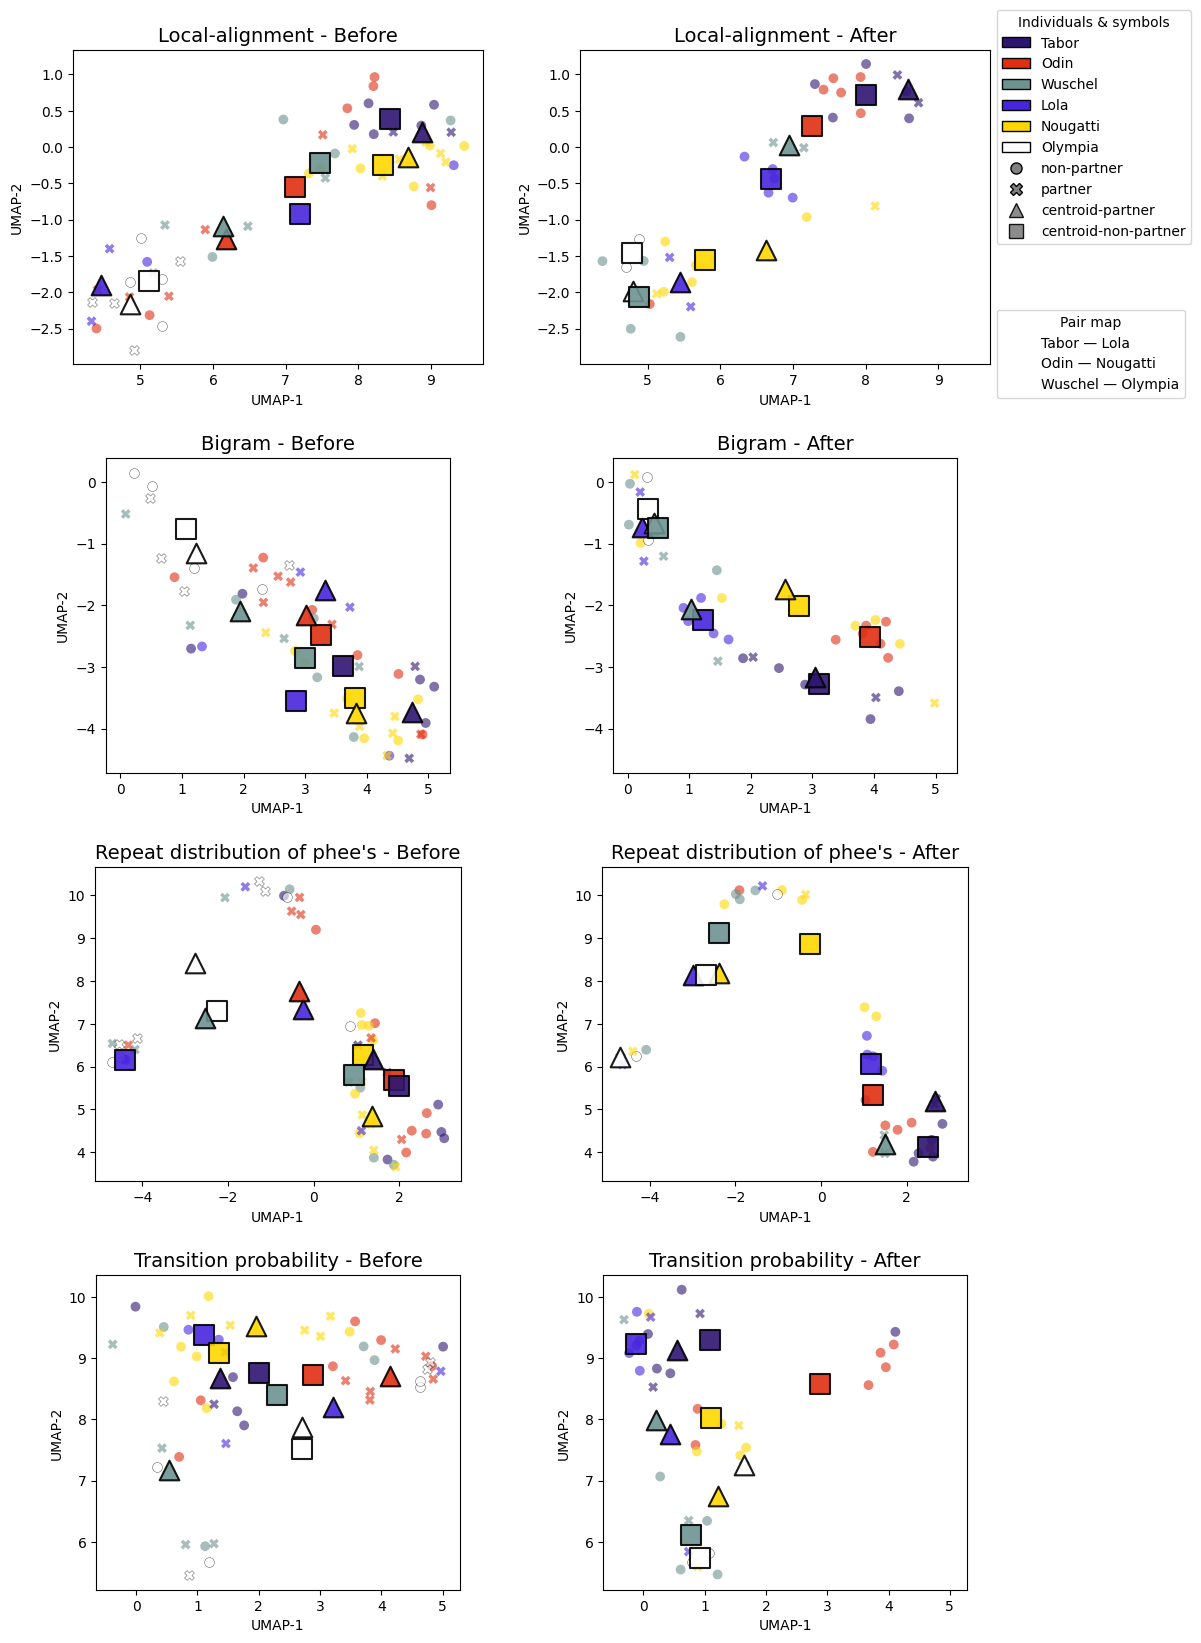

In [48]:
# %% ------------------------------------------------------------
#  UMAP grid • four distance metrics  +  centroids
# ------------------------------------------------------------
import umap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ── 0.  Which matrices to show (name, numpy array) --------------
DIST_MATS = [
    ("Local-alignment",                   D_sw),
    ("Bigram",                            D_bigram_eu),
    ("Repeat distribution of phee's",     D_repeat_eu),
    ("Transition probability",            D_tp_eu),
]

# ── 1.  Plotting constants --------------------------------------
POINT_MARK    = {"non-partner": "o", "partner": "X"}
CENTROID_MARK = {"non-partner": "s", "partner": "^"}   # square / triangle
POINT_ALPHA, CENT_ALPHA = 0.6, 0.90
PHASES = ["before", "after"]

# Pair mapping for the 2nd legend
pair_map = {
    "Tabor":   "Lola",
    "Odin":    "Nougatti",
    "Wuschel": "Olympia",
}

# ── 2.  Prepare canvas (4 rows × 2 cols) ------------------------
fig, axes = plt.subplots(
    nrows=len(DIST_MATS), ncols=len(PHASES),
    figsize=(12, 5 * len(DIST_MATS)),
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.3}
)

# ── 3.  Loop over the distance matrices -------------------------
for r, (title, D) in enumerate(DIST_MATS):

    # 3a. embed once per distance matrix
    reducer  = umap.UMAP(metric="precomputed", n_neighbors=50,
                         min_dist=0.01, random_state=42)
    emb      = reducer.fit_transform(D)        # (G, 2)
    df_embed = groups.copy()
    df_embed["U1"], df_embed["U2"] = emb.T

    # row‑wise axis limits (pad 5 %)
    pad        = 0.05
    xmin, xmax = df_embed["U1"].agg(["min", "max"])
    ymin, ymax = df_embed["U2"].agg(["min", "max"])
    dx, dy     = xmax - xmin, ymax - ymin
    xlim       = (xmin - pad * dx, xmax + pad * dx)
    ylim       = (ymin - pad * dy, ymax + pad * dy)

    # 3b.  two panels: before | after
    for c, phase in enumerate(PHASES):
        ax  = axes[r, c]
        sub = df_embed[df_embed["stage"] == phase]

        # scatter individual points --------------------------------
        for status, mark in POINT_MARK.items():
            pts = sub[sub["paired_status"] == status]
            for focal, color in PALETTE.items():
                sel = pts["focal ID"] == focal
                if not sel.any():
                    continue
                edge = "k" if color == "#ffffff" else "none"
                ax.scatter(pts.loc[sel, "U1"], pts.loc[sel, "U2"],
                           c=[color], marker=mark, edgecolors=edge,
                           linewidths=0.4, s=50, alpha=POINT_ALPHA)

        # scatter centroids ----------------------------------------
        cents = (sub.groupby(["focal ID", "paired_status"])[["U1", "U2"]]
                 .mean().reset_index())
        for _, row in cents.iterrows():
            edge = "k" if PALETTE[row["focal ID"]] == "#ffffff" else "k"
            ax.scatter(row["U1"], row["U2"],
                       marker=CENTROID_MARK[row["paired_status"]],
                       s=200, facecolor=PALETTE[row["focal ID"]],
                       edgecolor=edge, linewidth=1.5, alpha=CENT_ALPHA,
                       zorder=5)

        # tidy axes ------------------------------------------------
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("UMAP-1")
        ax.set_ylabel("UMAP-2")
        ax.set_title(f"{title} - {phase.capitalize()}", fontsize=14)

# ── 4a. Individuals & symbols legend ----------------------------
colour_handles = [Patch(facecolor=col, edgecolor='k', label=name)
                  for name, col in PALETTE.items()]
symbol_handles = [Line2D([], [], marker=m, linestyle='', markersize=8,
                         markeredgecolor='k', markerfacecolor='grey',
                         label=lab) for lab, m in POINT_MARK.items()]
cent_handles = [
    Line2D([], [], marker='^', linestyle='', markersize=10,
           markeredgecolor='k', markerfacecolor='grey',
           alpha=CENT_ALPHA, label='centroid‑partner'),
    Line2D([], [], marker='s', linestyle='', markersize=10,
           markeredgecolor='k', markerfacecolor='grey',
           alpha=CENT_ALPHA, label='centroid‑non‑partner')
]
handles_main  = colour_handles + symbol_handles + cent_handles
labels_main   = [h.get_label() for h in handles_main]

fig.legend(handles_main, labels_main,
           title="Individuals & symbols",
           ncol=1, loc="upper left",
           bbox_to_anchor=(0.9, 0.90),  # top‑right outside
           borderaxespad=0.0)

# ── 4b. Pair‑map legend (immediately below the first) -----------
pair_handles = [
    Line2D([], [], marker='',
           linestyle='', label=f"{male} — {partner}")
    for male, partner in pair_map.items()
]
fig.legend(pair_handles, [h.get_label() for h in pair_handles],
           title="Pair map",
           ncol=1, loc="upper left",
           bbox_to_anchor=(0.9, 0.75),  # below the first legend
           borderaxespad=0.0)

plt.show()


basic discriptive analysis of the sequnce data

/var/folders/9f/6hz55r1d6yx1hbcw4ql3hwm40000gq/T/ipykernel_95855/641205039.py:81: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



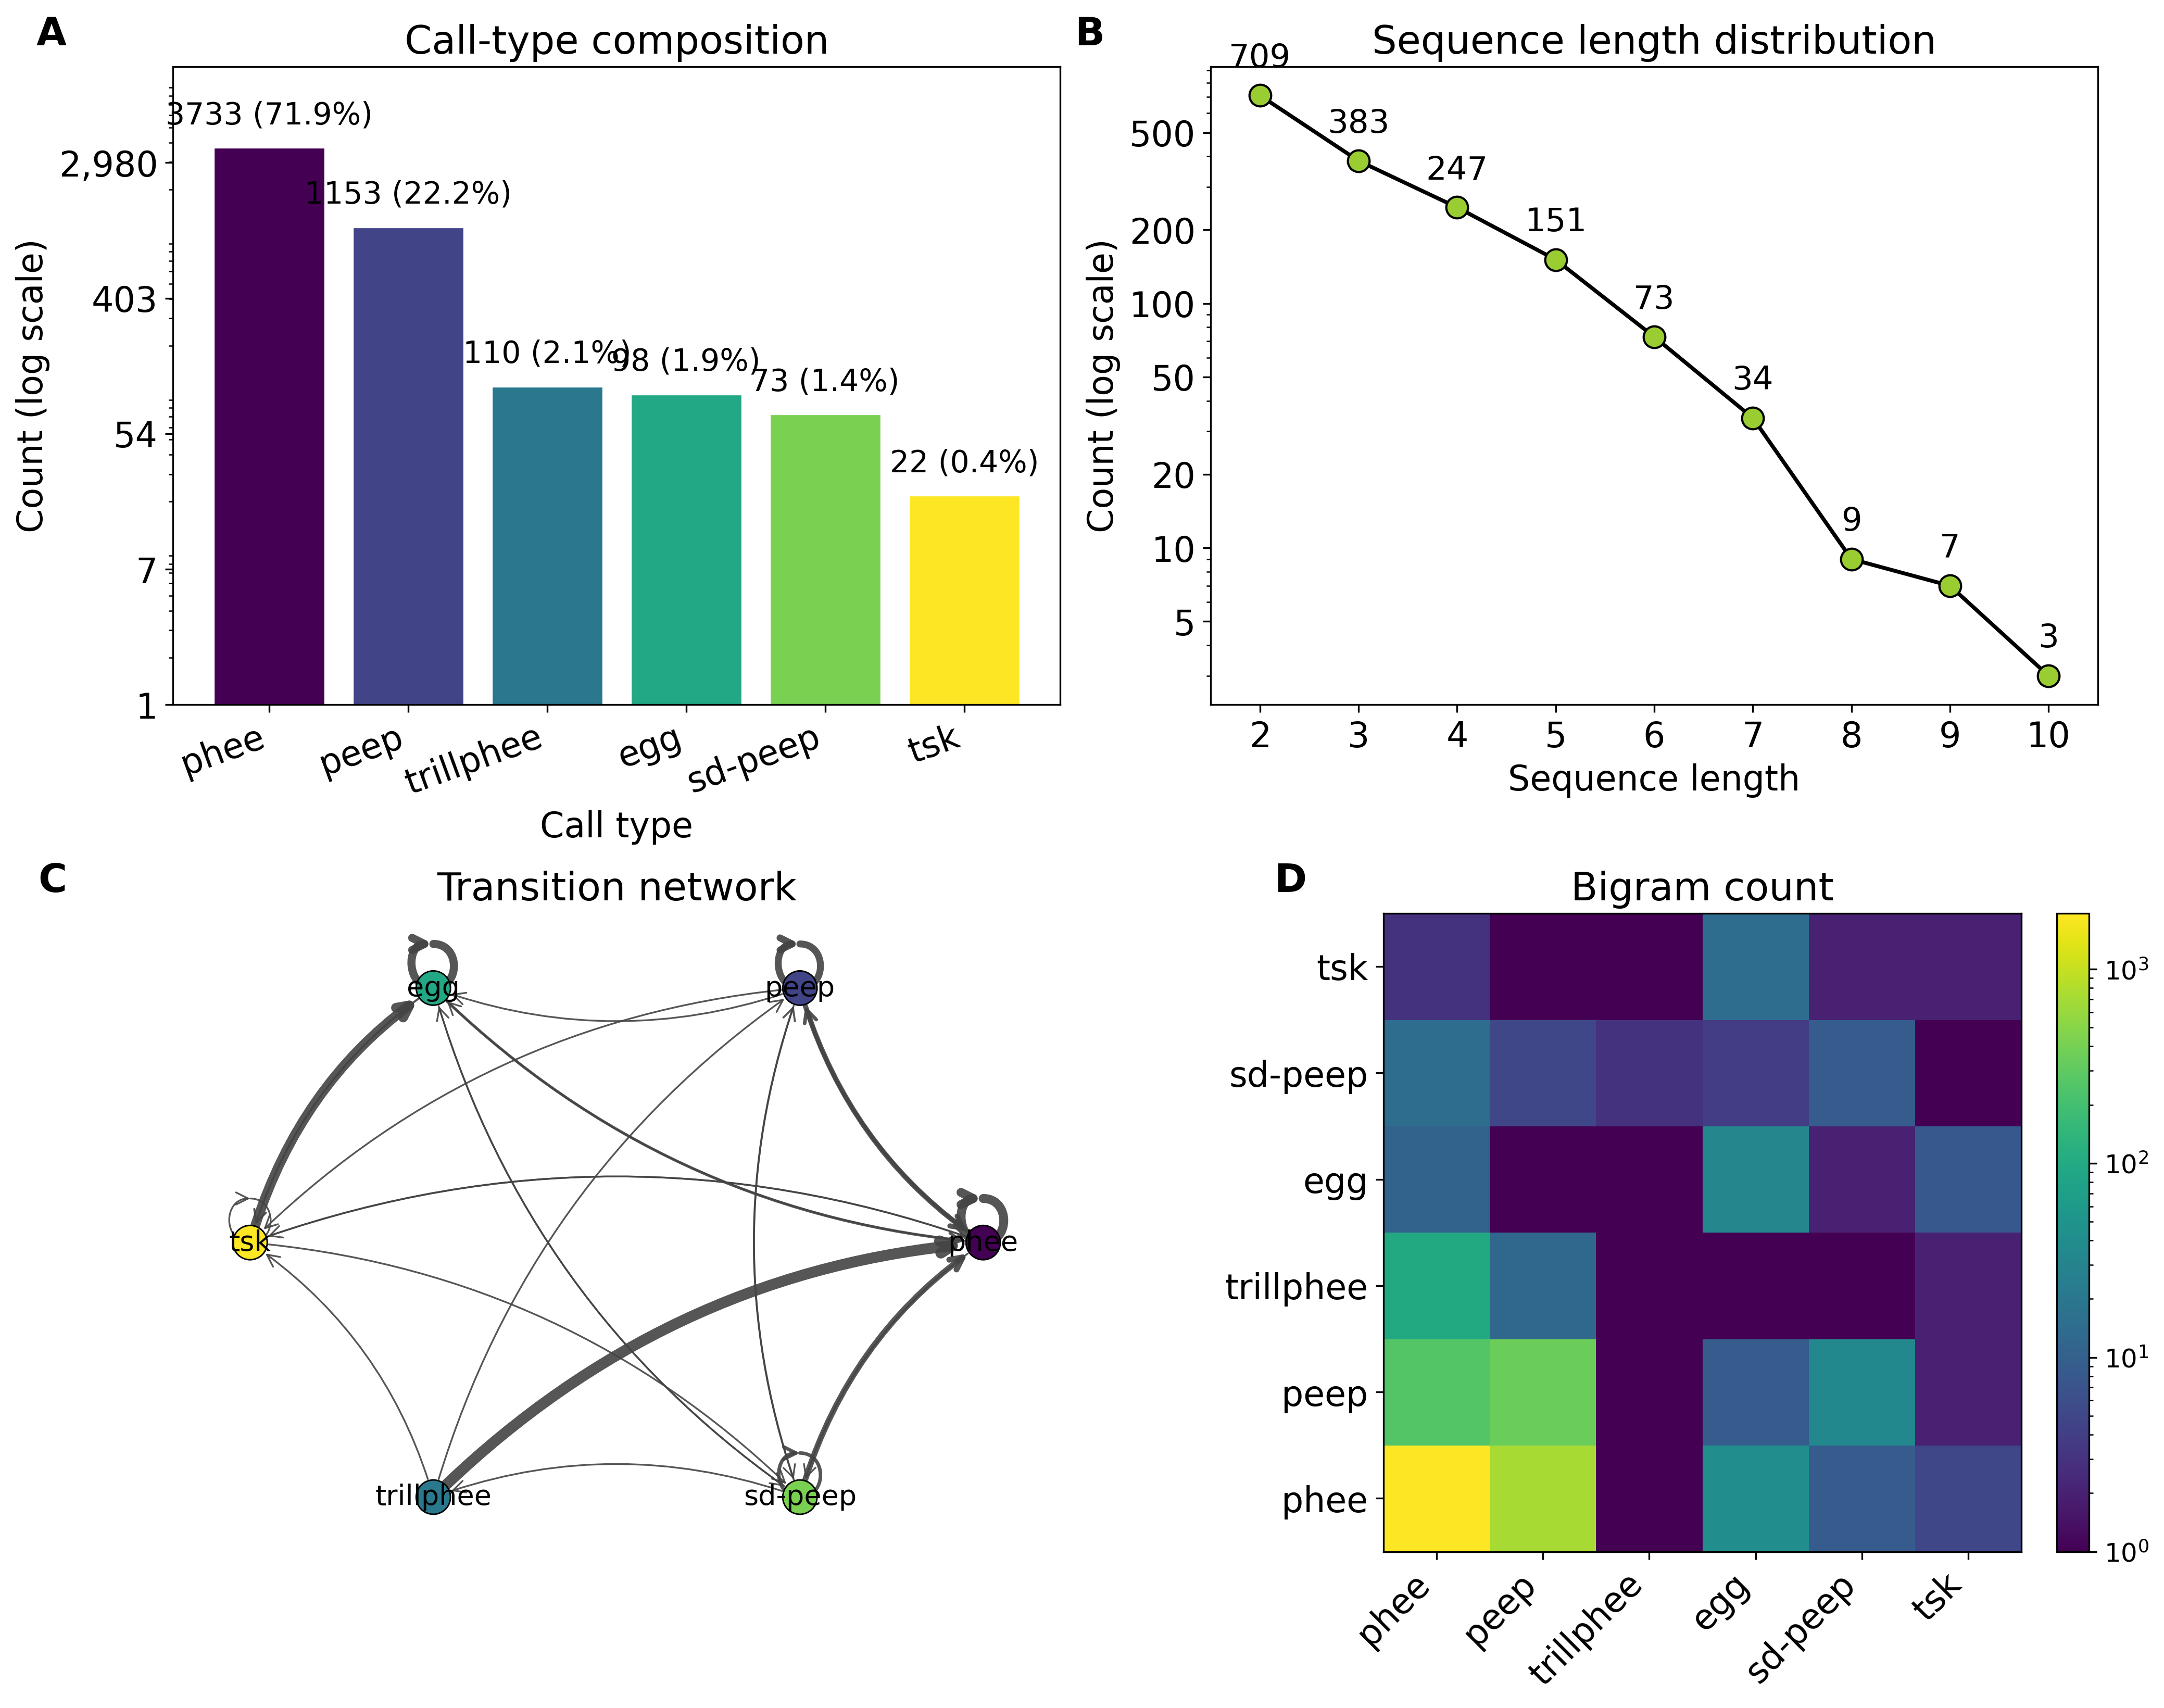

In [50]:
# -------------------------------------------------------------------
#   Descriptive figure • composition (bar) • length (line+points)
#   • transition network • bigram heatmap (Viridis + full call names)
# -------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
from pathlib import Path
from collections import Counter

# ---------- Matplotlib global style ---------------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})

# ---------- 1. Load & clean data ------------------------------------
BASE_DIR = Path.cwd().parent
CSV_PATH = BASE_DIR / "seqeunce data" / "Processed_seq_data.csv"

df = (pd.read_csv(CSV_PATH, usecols=["true_sequence"])
        .dropna(subset=["true_sequence"]))
df["tokens"] = df["true_sequence"].str.strip().apply(list)

# drop tokens not part of the annotated repertoire
DROP_NOTES = {"n", "a"}
df["tokens"] = df["tokens"].apply(lambda t: [x for x in t if x not in DROP_NOTES])
df = df[df["tokens"].str.len() > 0].reset_index(drop=True)

# ---------- 1b. Letter -> full call name mapping --------------------
NAME_MAP = {
    # Phee repetitions (A,B,C,...) are all "phee"
    "A": "phee",
    "B": "phee",
    "C": "phee",
    "D": "phee",
    "E": "phee",
    "F": "phee",
    "P": "peep",
    "K": "egg",
    "T": "tsk",
    "O": "ock",
    "R": "trillphee",
    "S": "sd-peep",
}

# Map tokens to their full names (phee variants collapse to "phee")
df["tokens_full"] = df["tokens"].apply(lambda lst: [NAME_MAP.get(x, x) for x in lst])

# ---------- 2. Tallies & matrices -----------------------------------
note_counts = Counter(tok for lst in df["tokens_full"] for tok in lst)
# sort call types by total count (descending)
notes, counts = zip(*sorted(note_counts.items(), key=lambda kv: -kv[1]))
total = int(sum(counts))

alphabet = list(notes)
A = len(alphabet)
idx = {c: i for i, c in enumerate(alphabet)}

# Bigram counts (B) and row-normalized transition probabilities (P)
B = np.zeros((A, A), dtype=float)
for tok in df["tokens_full"]:
    for a, b in zip(tok[:-1], tok[1:]):
        B[idx[a], idx[b]] += 1
row_sums = B.sum(axis=1, keepdims=True)
P = np.divide(B, np.where(row_sums == 0, 1, row_sums))

seq_lengths = df["tokens_full"].str.len()

# ---------- 2b. Shared Viridis palette ------------------------------
cmap = cm.get_cmap("viridis", A)
color_map = {n: mcolors.to_hex(cmap(i)) for i, n in enumerate(alphabet)}

# ---------- 3. Figure layout ----------------------------------------
fig, ax = plt.subplots(2, 2, figsize=(14, 11))
plt.subplots_adjust(hspace=0.32, wspace=0.55)

# Helper: add panel tag (A–D)
def panel_tag(panel_ax, tag):
    panel_ax.text(-0.12, 1.08, tag, transform=panel_ax.transAxes,
                  fontsize=18, fontweight="bold", va="top", ha="right")

# === A. Note composition (sorted horizontal bar) =====================
# === A. Call-type composition (vertical bars, natural-log y) ==========
ax_comp = ax[0, 0]
panel_tag(ax_comp, "A")
ax_comp.set_title("Call-type composition")

notes_sorted  = list(notes)  # already sorted descending by count
counts_sorted = np.array(counts)
colors_sorted = [color_map[n] for n in notes_sorted]
perc_sorted   = [c / total * 100 for c in counts_sorted]

x = np.arange(len(notes_sorted))
bars = ax_comp.bar(x, counts_sorted,
                   color=colors_sorted, edgecolor="white", linewidth=.8)

# X-axis formatting
ax_comp.set_xticks(x)
ax_comp.set_xticklabels(notes_sorted, rotation=20, ha="right")
ax_comp.set_xlabel("Call type")

# ---------- Natural-log scale on Y but with readable labels ----------
ax_comp.set_yscale("log")                     # use log transform for spacing
ax_comp.yaxis.set_major_locator(LogLocator(base=np.e))  # natural log
ax_comp.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y):,d}"))

ax_comp.set_ylabel("Count (log scale)")
ymax = counts_sorted.max()
ax_comp.set_ylim(1, ymax * 3.3)

# ---------- Annotations ----------
for xi, bar, c, p in zip(x, bars, counts_sorted, perc_sorted):
    ax_comp.annotate(f"{int(c)} ({p:.1f}%)",
                     xy=(xi, c),
                     xytext=(0, 8),
                     textcoords="offset points",
                     ha="center", va="bottom",
                     fontsize=14, color="black")
# === B. Sequence length distribution (points + line) ================
ax_len = ax[0, 1]
panel_tag(ax_len, "B")
ax_len.set_title("Sequence length distribution")

lens = seq_lengths[(seq_lengths >= 2) & (seq_lengths <= 10)]
len_counts = lens.value_counts().sort_index()
x_vals, y_vals = len_counts.index.to_numpy(), len_counts.values

ax_len.plot(x_vals, y_vals, marker='o', markersize=10, linewidth=1.8,
            color="black", markerfacecolor="yellowgreen")

ax_len.set_yscale("log")
ax_len.yaxis.set_major_locator(LogLocator(base=10, subs=(1., 2., 5.)))
ax_len.yaxis.set_minor_locator(LogLocator(base=10, subs=tuple(range(1, 10))))
ax_len.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y):d}"))
ax_len.set_xticks(range(2, 11))
ax_len.set_xlim(1.5, 10.5)
ax_len.set_xlabel("Sequence length")
ax_len.set_ylabel("Count (log scale)")

# Larger labels farther from points
for x, y in zip(x_vals, y_vals):
    ax_len.annotate(f"{int(y)}", (x, y),
                    textcoords="offset points", xytext=(0, 10),
                    ha="center", va="bottom", fontsize=15)

# === C. Transition network ==========================================
ax_net = ax[1, 0]
panel_tag(ax_net, "C")
ax_net.set_title("Transition network")
ax_net.set_axis_off()

NODE_SCALE = 0.12
EDGE_SCALE = 5.5

G = nx.DiGraph()
for n, c in note_counts.items():
    G.add_node(n, size=c)

for i, a in enumerate(alphabet):
    for j, b in enumerate(alphabet):
        if P[i, j] > 0:
            G.add_edge(a, b, weight=P[i, j])

pos = nx.circular_layout(G)

# edges (curved)
for (u, v) in G.edges():
    width = max(G.edges[u, v]["weight"] * EDGE_SCALE + 0.2, 0.8)
    rad   = 0.18 if (u < v) else -0.18
    nx.draw_networkx_edges(
        G, pos, ax=ax_net, edgelist=[(u, v)],
        width=width, arrowstyle="->", arrowsize=14,
        connectionstyle=f"arc3,rad={rad}", alpha=.9, edge_color="#444444"
    )

# nodes
node_sizes  = [ 250 for _, d in G.nodes(data=True)]
node_colors = [color_map[n] for n in G.nodes]
nx.draw_networkx_nodes(G, pos, ax=ax_net,
                       node_size=node_sizes,
                       node_color=node_colors,
                       edgecolors="k", linewidths=.7)
nx.draw_networkx_labels(G, pos, ax=ax_net, font_size=13, font_weight="regular")

# === D. Bigram heat-map =============================================
ax_hm = ax[1, 1]
panel_tag(ax_hm, "D")
im = ax_hm.imshow(B + 1, origin="lower", aspect="equal",
                  norm=LogNorm(vmin=1, vmax=(B + 1).max()),
                  cmap="viridis")
ax_hm.set_xticks(range(A)); ax_hm.set_xticklabels(alphabet, rotation=45, ha="right")
ax_hm.set_yticks(range(A)); ax_hm.set_yticklabels(alphabet)
ax_hm.set_title("Bigram count")

# Colorbar with readable ticks
cbar = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
# fig.savefig("figure2_descriptives.png", dpi=300, bbox_inches="tight")
plt.show()

# save as svg as each element is vector graphics

fig.savefig("figure2_descriptives.svg", dpi=300, bbox_inches="tight")


In [51]:
import numpy as np
import pandas as pd

# --- Compute sequence lengths from the same df used in the figure ---
seq_lengths = df["tokens_full"].str.len()
total_sequences = len(seq_lengths)

# --- Basic statistics ---
mean_len = np.mean(seq_lengths)
median_len = np.median(seq_lengths)
std_len = np.std(seq_lengths, ddof=1)  # sample std dev

print(f"Total sequences analyzed: {total_sequences}")
print(f"Mean length:   {mean_len:.2f}")
print(f"Median length: {median_len:.2f}")
print(f"Std. deviation: {std_len:.2f}")

# --- Distribution up to length 7 ---
print("\nSequences ≤ given length:")
for x in range(2, 8):  # lengths 2 through 7 inclusive
    n = np.sum(seq_lengths <= x)
    pct = n / total_sequences * 100
    print(f"  ≤ {x} elements: {n:4d} sequences ({pct:5.1f}%)")

# --- Optionally, produce a summary table as a DataFrame ---
summary_df = (
    pd.DataFrame({
        "≤ length": list(range(2, 8)),
        "count": [np.sum(seq_lengths <= x) for x in range(2, 8)],
    })
)
summary_df["percent"] = summary_df["count"] / total_sequences * 100
summary_df

Total sequences analyzed: 1619
Mean length:   3.21
Median length: 3.00
Std. deviation: 1.49

Sequences ≤ given length:
  ≤ 2 elements:  709 sequences ( 43.8%)
  ≤ 3 elements: 1092 sequences ( 67.4%)
  ≤ 4 elements: 1339 sequences ( 82.7%)
  ≤ 5 elements: 1490 sequences ( 92.0%)
  ≤ 6 elements: 1563 sequences ( 96.5%)
  ≤ 7 elements: 1597 sequences ( 98.6%)


,≤ length,count,percent
0,2,709,43.792464
1,3,1092,67.449043
2,4,1339,82.705374
3,5,1490,92.032119
4,6,1563,96.541075
5,7,1597,98.641137
